In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import astropy.units as u

import gala.coordinates as gc

In [2]:
plt.style.use('notebook')

In [3]:
t = Table(fits.getdata('../data/pal5_ls_lite.fits'))

In [4]:
a2ebv = [3.995, 3.214, 2.165, 1.592, 1.211, 1.064]
bands = ['u', 'g', 'r', 'i', 'z', 'Y']

g = 22.5 - 2.5*np.log10(t['flux_g']) - t['ebv']*a2ebv[1]
r = 22.5 - 2.5*np.log10(t['flux_r']) - t['ebv']*a2ebv[2]

points = np.array([g-r, g]).T

/home/ana/install/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/ana/install/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/ana/install/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/home/ana/install/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


In [5]:
ceq = coord.SkyCoord(ra=t['ra']*u.deg, dec=t['dec']*u.deg, frame='icrs')
cpal = ceq.transform_to(gc.Pal5)

wangle = 180*u.deg

In [6]:
p = [0.018,0.14,-0.7]
poly_track_coarse = np.poly1d(p)

In [7]:
delta_phi2 = 0.4
phi2_mask = ((cpal.phi2.deg<poly_track_coarse(cpal.phi1.wrap_at(wangle).deg ) + delta_phi2) & 
             (cpal.phi2.deg>poly_track_coarse(cpal.phi1.wrap_at(wangle).deg) - delta_phi2))

In [19]:
bin_spacing = 3*u.deg
bin_width = 3*u.deg

be0 = np.arange(-15, 10, bin_spacing.to(u.deg).value)*u.deg
be1 = be0 + bin_width

bc = 0.5 * (be0 + be1)
N = np.size(bc)

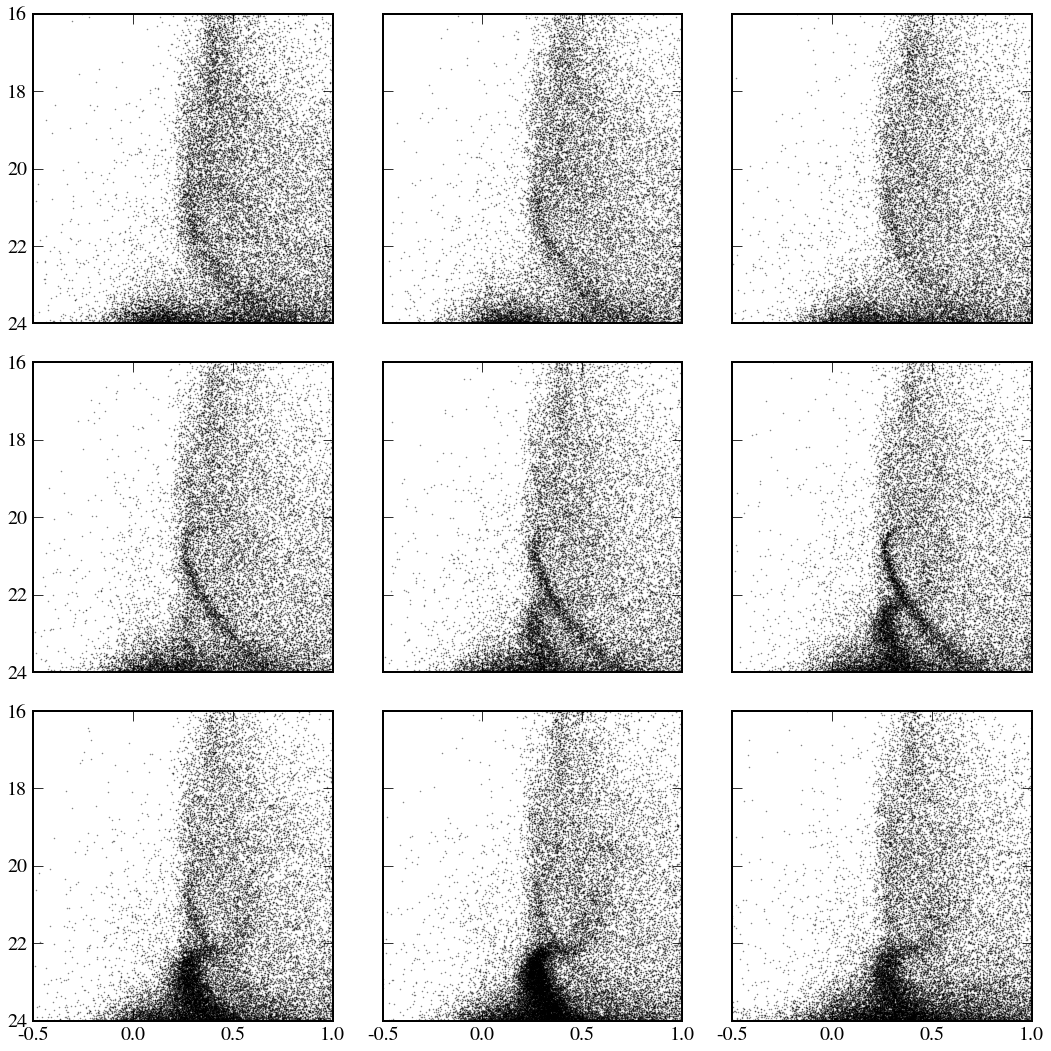

In [21]:
fig, ax = plt.subplots(3,3,figsize=(15,15), sharex=True, sharey=True)

for i in range(N):
    irow = np.int64(i/3)
    icol = i%3
    plt.sca(ax[irow][icol])
    
    ind = phi2_mask & (cpal.phi1.wrap_at(wangle)>be0[i]) & (cpal.phi1.wrap_at(wangle)<=be1[i])
    plt.plot(g[ind] - r[ind], g[ind], 'k.', ms=1, alpha=0.5)

    plt.xlim(-0.5,1)
    plt.ylim(24,16)
plt.tight_layout()

## Estimate distances

In [22]:
iso = Table.read('../data/mist_11.5_-1.30.cmd', format='ascii.commented_header', header_start=12)
phasecut = (iso['phase']>=0) & (iso['phase']<5)
iso = iso[phasecut]

In [24]:
distance_app = 22.5*u.kpc
dm = 5*np.log10((distance_app.to(u.pc)).value)-5

# main sequence + rgb
i_gr = iso['DECam_g']-iso['DECam_r'] + 0.06
i_g = iso['DECam_g']+dm

# i_left = i_gr - 0.12*(i_g/28)**5
# i_right = i_gr + 0.12*(i_g/28)**5

# poly = np.hstack([np.array([i_left, i_g]), np.array([i_right[::-1], i_g[::-1]])]).T
# ind = (poly[:,1]<23.7) & (poly[:,1]>20)
# poly_main = poly[ind]
# path_main = mpl.path.Path(poly_main)

# cmd_mask = path_main.contains_points(points)

In [49]:
delta_dm = np.zeros(N)
delta_dm[8] = -0.3
delta_dm[7] = -0.2
delta_dm[6] = -0.15

# from ibata+2016
delta_dm[0] = 0.1

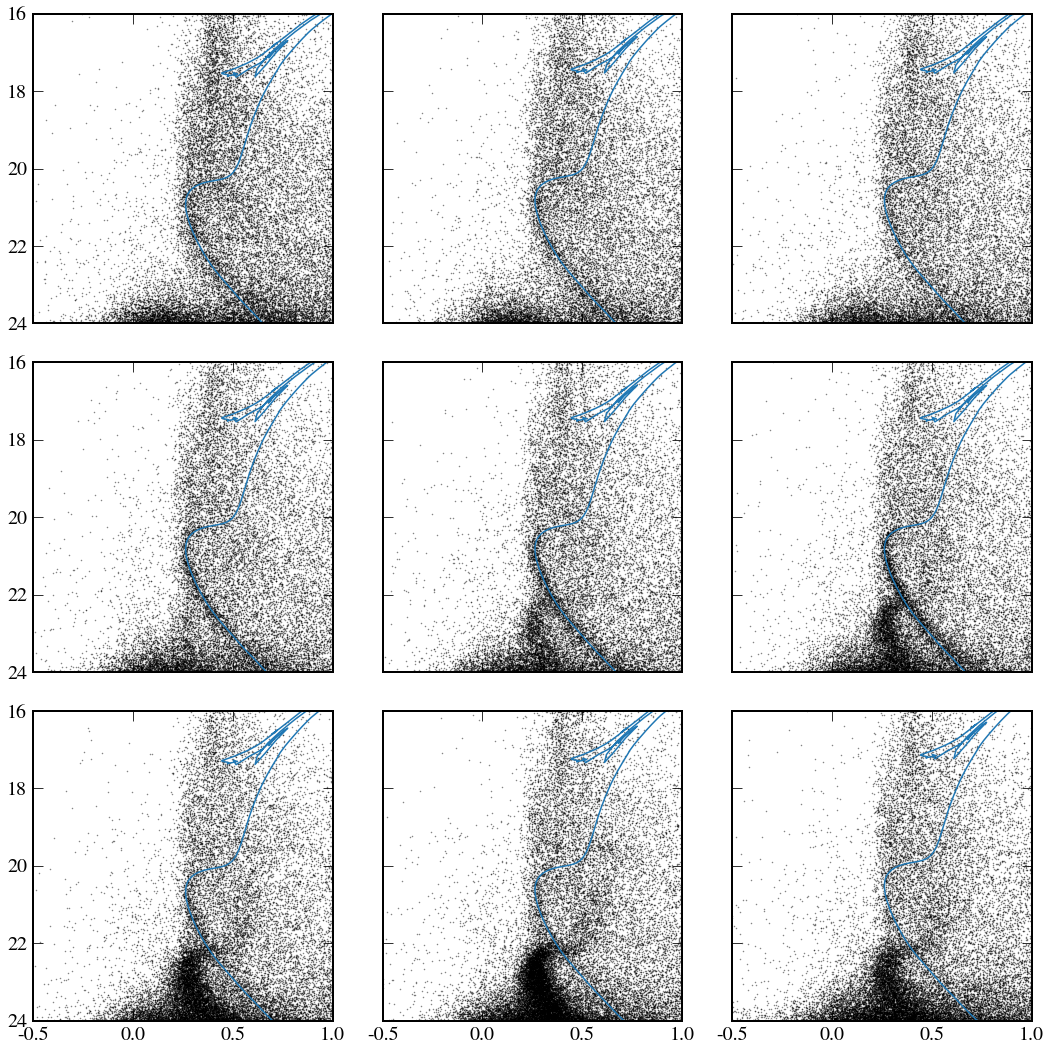

In [50]:
fig, ax = plt.subplots(3,3,figsize=(15,15), sharex=True, sharey=True)

for i in range(N):
    irow = np.int64(i/3)
    icol = i%3
    plt.sca(ax[irow][icol])
    
    ind = phi2_mask & (cpal.phi1.wrap_at(wangle)>be0[i]) & (cpal.phi1.wrap_at(wangle)<=be1[i])
    plt.plot(g[ind] - r[ind], g[ind], 'k.', ms=1, alpha=0.5)
    
    plt.plot(i_gr, i_g+delta_dm[i], '-')

    plt.xlim(-0.5,1)
    plt.ylim(24,16)
plt.tight_layout()

In [51]:
pfit = np.polyfit(bc[np.r_[0,6:9]].value, delta_dm[np.r_[0,6:9]], deg=2)
dm_polyfit = np.poly1d(pfit)

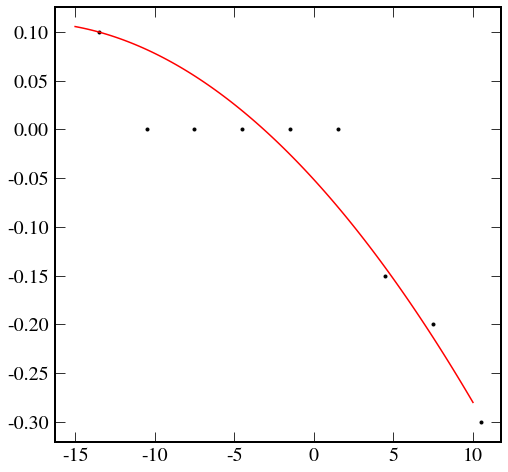

In [52]:
phi1_grid = np.linspace(-15,10,100)
dm_grid = dm_polyfit(phi1_grid)
plt.plot(bc, delta_dm, 'k.')
plt.plot(phi1_grid, dm_grid, 'r-')

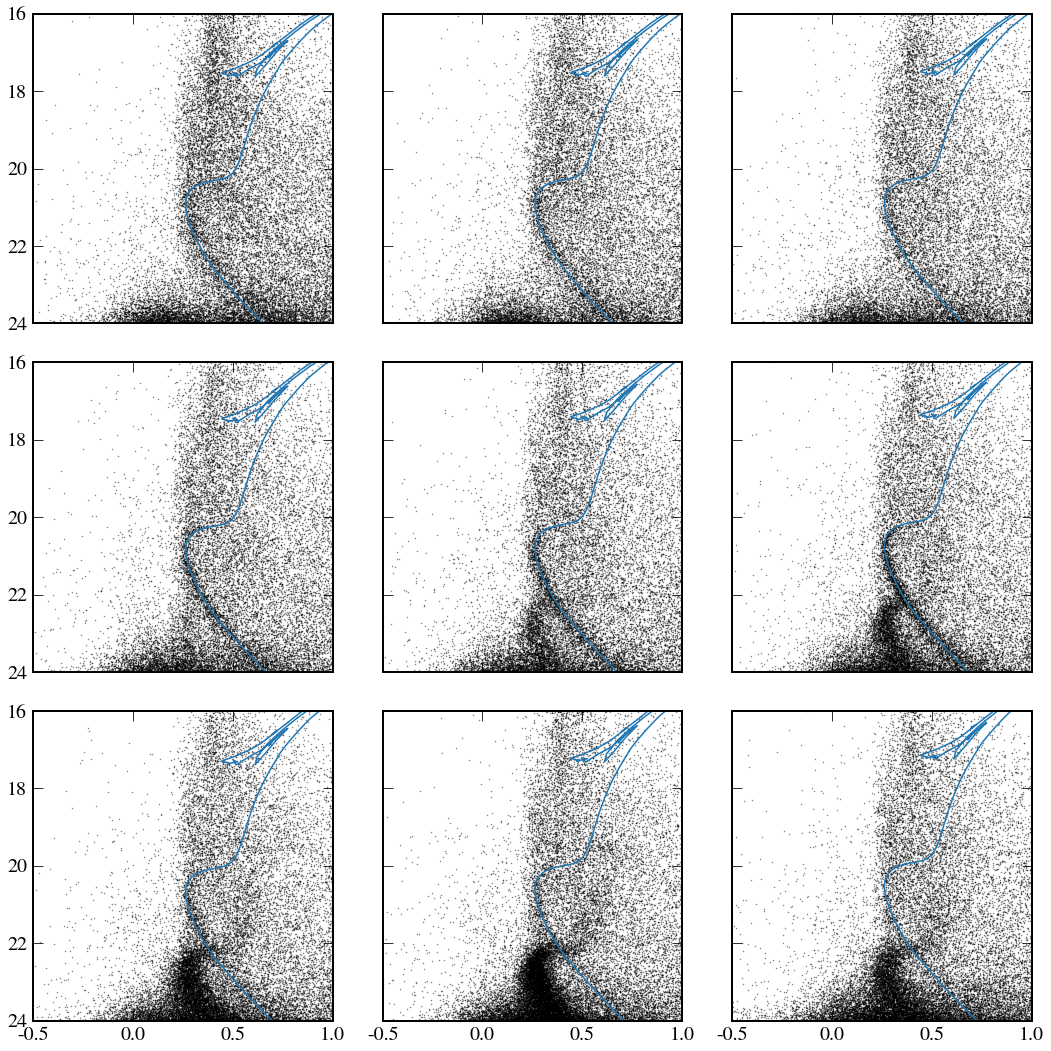

In [53]:
fig, ax = plt.subplots(3,3,figsize=(15,15), sharex=True, sharey=True)

for i in range(N):
    irow = np.int64(i/3)
    icol = i%3
    plt.sca(ax[irow][icol])
    
    ind = phi2_mask & (cpal.phi1.wrap_at(wangle)>be0[i]) & (cpal.phi1.wrap_at(wangle)<=be1[i])
    plt.plot(g[ind] - r[ind], g[ind], 'k.', ms=1, alpha=0.5)
    
    plt.plot(i_gr, i_g + dm_polyfit(bc[i].value), '-')

    plt.xlim(-0.5,1)
    plt.ylim(24,16)
plt.tight_layout()